In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
from datetime import datetime
import os
import time
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
main_url="https://townhall.virginia.gov/L/Comments.cfm?GdocForumID=1953"

orig_url="https://townhall.virginia.gov/L/GDocForum.cfm?GDocForumID=452"

## Alt method - full comments page, paginated

In [3]:
base_url = "https://townhall.virginia.gov/L/ViewComments.cfm?GdocForumID=1953"
params = {"vPage": 1,
  "vPerPage": 999,
  "sub1": "go"}

In [6]:
pagecount = 99
params['vPage'] = 1

dfc = pd.DataFrame()

while params['vPage'] <= pagecount:
    r = requests.post(base_url, data=params)
    soup = BeautifulSoup(r.text, "lxml")
    try:
        pagecount = int(soup.find(id="page").div.a.text)
    except:
        pagecount = 0
    print(f"page {params['vPage']}/{pagecount}")
    params['vPage'] += 1
    boxes = soup.find_all(attrs={"class": "Cbox"})
    for box in boxes:
        comment = {"Date": unicodedata.normalize("NFKD", box.contents[1].div.get_text(strip=True)),
           "Commenter": box.contents[3].contents[2].strip(),
           "Comment Title": box.contents[3].find_all('strong')[1].get_text(strip=True),
           "Comment": box.find(attrs={"class":"divComment"}).get_text(strip=True),
           "CommentID": int(box.find(attrs={"class":"linklight"}).get_text(strip=True))}
        dfc = dfc.append(comment, ignore_index=True)


page 1/72
page 2/72
page 3/72
page 4/72
page 5/72
page 6/72
page 7/72
page 8/72
page 9/72
page 10/72
page 11/72
page 12/72
page 13/72
page 14/72
page 15/72
page 16/72
page 17/72
page 18/72
page 19/72
page 20/72
page 21/72
page 22/72
page 23/72
page 24/72
page 25/72
page 26/72
page 27/72
page 28/72
page 29/72
page 30/72
page 31/72
page 32/72
page 33/72
page 34/72
page 35/72
page 36/72
page 37/72
page 38/72
page 39/72
page 40/72
page 41/72
page 42/72
page 43/72
page 44/72
page 45/72
page 46/72
page 47/72
page 48/72
page 49/72
page 50/72
page 51/72
page 52/72
page 53/72
page 54/72
page 55/72
page 56/72
page 57/72
page 58/72
page 59/72
page 60/72
page 61/72
page 62/72
page 63/72
page 64/72
page 65/72
page 66/72
page 67/72
page 68/72
page 69/72
page 70/72
page 71/72
page 72/72


In [7]:
print(dfc.shape)
print(len(dfc['CommentID'].unique()))

(71298, 5)
71260


In [8]:
dfc.to_csv('all_comments.csv')

In [6]:
# read back from csv

In [9]:
# feature eng

In [10]:
dfc['Date'] = pd.to_datetime(dfc['Date'], errors='coerce') 

In [11]:
dfc['alltext'] = (dfc['Comment Title'] + ' ' + dfc['Comment']).str.lower()

In [12]:
dfc['support'] = dfc['Comment Title'].str.lower().str.contains('support')
dfc['oppose'] = dfc['Comment Title'].str.lower().str.contains('oppose')

In [13]:

print(f"Total: {dfc.shape[0]} comments")
print("Using title alone...")
print(f"Support policy: {dfc['support'].sum()} comments, avg length {dfc.loc[dfc['support']]['Comment'].str.len().mean():.0f}")
print(f"Oppose policy: {dfc['oppose'].sum()} comments, avg length {dfc.loc[dfc['oppose']]['Comment'].str.len().mean():.0f}")
print(f"Unclear: {(~dfc['support'] & ~dfc['oppose']).sum()} comments, avg length {dfc.loc[(~dfc['support'] & ~dfc['oppose'])]['Comment'].str.len().mean():.0f}")
print(f"Intersect: {(dfc['support'] & dfc['oppose']).sum()}")

Total: 71298 comments
Using title alone...
Support policy: 15077 comments, avg length 275
Oppose policy: 23065 comments, avg length 314
Unclear: 33513 comments, avg length 317
Intersect: 357


In [14]:
# process text field
cleantext = []

for sentence in dfc['alltext']:
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(sentence))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    cleantext.append(processed_feature)
    
dfc['cleantext'] = cleantext

In [15]:
# segment training data from unknown data

dfc['label'] = 'Unknown'
dfc.loc[dfc['support'],'label'] = 'Support'
dfc.loc[dfc['oppose'],'label'] = 'Oppose'
dfc.loc[(dfc['support'] & dfc['oppose']), 'label'] = 'Unknown'

train = dfc.loc[dfc['label'] != 'Unknown',:]
unk = dfc.loc[dfc['label'] == 'Unknown']

In [16]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(train['cleantext']).toarray()


In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(processed_features, train['label'], test_size=0.2, random_state=0)

In [18]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [19]:
predictions = text_classifier.predict(X_test)

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[4513    4]
 [  73 2896]]
              precision    recall  f1-score   support

      Oppose       0.98      1.00      0.99      4517
     Support       1.00      0.98      0.99      2969

    accuracy                           0.99      7486
   macro avg       0.99      0.99      0.99      7486
weighted avg       0.99      0.99      0.99      7486

0.989714133048357


In [21]:
unk_input = vectorizer.transform(unk['cleantext']).toarray() # don't re-fit the vectorizer!
real_preds = text_classifier.predict(unk_input)
unk['pred'] = real_preds

<ipython-input-21-d550d6c9a0ca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unk['pred'] = real_preds


In [22]:
unk.groupby(['pred']).count()

,Comment,Comment Title,CommentID,Commenter,Date,alltext,support,oppose,cleantext,label
pred,,,,,,,,,,
Oppose,26770,26770,26770,26770,26770,26770,26770,26770,26770,26770
Support,7100,7100,7100,7100,7100,7100,7100,7100,7100,7100


In [23]:
train.groupby(['label']).count()

,Comment,Comment Title,CommentID,Commenter,Date,alltext,support,oppose,cleantext
label,,,,,,,,,
Oppose,22708,22708,22708,22708,22708,22708,22708,22708,22708
Support,14720,14720,14720,14720,14720,14720,14720,14720,14720


In [24]:
train['pred'] = ''
output_df = train.loc[:,['CommentID','Commenter','Comment Title','Comment','Date','label','pred']]
output_df = output_df.append(unk.loc[:,['CommentID','Commenter','Comment Title','Comment','Date','label','pred']])

<ipython-input-24-d4fb34fd6823>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['pred'] = ''


In [25]:
output_df.to_csv('output.csv',index=False)

In [26]:
anon = output_df.loc[output_df['Commenter'].str.lower().str.strip() == 'anonymous']
anon['merged'] = anon['pred'].replace('',np.NaN).fillna(anon['label'])
anon.groupby('merged')['CommentID'].count()

<ipython-input-26-4c0ba5a8c74c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anon['merged'] = anon['pred'].replace('',np.NaN).fillna(anon['label'])


merged
Oppose     26289
Support    11605
Name: CommentID, dtype: int64

In [25]:
anon.shape

(32030, 8)

## Timeseries

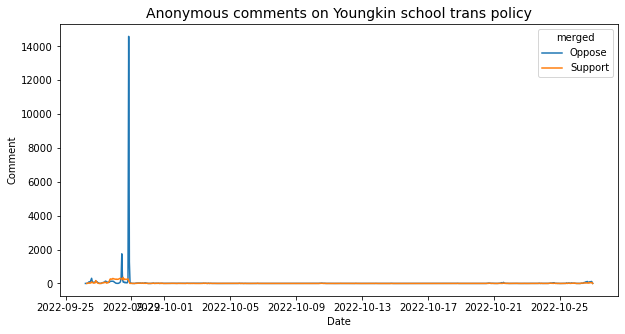

In [27]:
anon_ts = anon.set_index('Date').groupby([pd.Grouper(freq='1h'), 'merged']).count().loc[:,['Comment']].reset_index()

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = 'Date', y = 'Comment', data = anon_ts, hue = 'merged', ax=ax)
ax.set_title('Anonymous comments on Youngkin school trans policy', fontsize=14)
plt.savefig("images/anon_ts.png", facecolor='white')
plt.show()

In [28]:
anon_dups = anon.groupby(['Comment Title','Comment']).agg({"CommentID":'count','Date':['min','max']})
anon_dups.columns = ['count','min_date','max_date']
anon_dups['range'] = (anon_dups['max_date'] - anon_dups['min_date'])
anon_dups.sort_values('count', ascending=False).head(10)

,,count,min_date,max_date,range
Comment Title,Comment,,,,
Leave Trans Kids Alone,"This will hurt kids. Don't be mean, Youngkin!",4420,2022-09-28 20:01:00,2022-09-28 21:27:00,0 days 01:26:00
Strongly Oppose,"This will hurt kids. Don't be mean, Youngkin!",4224,2022-09-28 19:42:00,2022-09-28 21:27:00,0 days 01:45:00
Youngkin Hates,"This will hurt kids. Don't be mean, Youngkin!",2633,2022-09-28 20:01:00,2022-09-28 21:27:00,0 days 01:26:00
Glenn Youngkin Is A Bot,"This will hurt kids. Don't be mean, Youngkin!",1363,2022-09-28 20:08:00,2022-09-28 20:25:00,0 days 00:17:00
This Policy Makes The Baby Jesus Cry,"This will hurt kids. Don't be mean, Youngkin!",1070,2022-09-28 20:11:00,2022-09-28 20:25:00,0 days 00:14:00
Glenn Youngkin Wears A Hairpiece,"This will hurt kids. Don't be mean, Youngkin!",1065,2022-09-28 20:11:00,2022-09-28 20:25:00,0 days 00:14:00
Glenn Youngkin Smells Like Stale Farts,"This will hurt kids. Don't be mean, Youngkin!",812,2022-09-28 20:12:00,2022-09-28 20:25:00,0 days 00:13:00
LOCK YOUNGKIN UP,As anti american as you can get!,577,2022-09-28 10:18:00,2022-09-28 10:22:00,0 days 00:04:00
VOTE HIM OUT,This is cruel to our children,432,2022-09-28 10:12:00,2022-09-28 10:16:00,0 days 00:04:00


<AxesSubplot:>

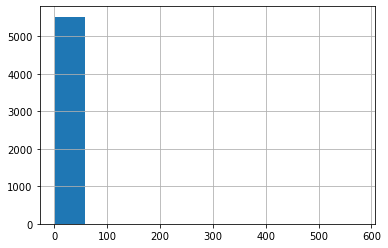

In [275]:
anon_dups['count'].hist()

In [29]:
# drop dups with >5
anon_dups.reset_index(inplace=True)
anon_dups = anon_dups.loc[(anon_dups['count']>5)]
anon_dups.set_index(['Comment Title','Comment'], inplace=True)

In [30]:
anon_dups.sort_values('count', ascending=False).head(5)


,,count,min_date,max_date,range
Comment Title,Comment,,,,
Leave Trans Kids Alone,"This will hurt kids. Don't be mean, Youngkin!",4420,2022-09-28 20:01:00,2022-09-28 21:27:00,0 days 01:26:00
Strongly Oppose,"This will hurt kids. Don't be mean, Youngkin!",4224,2022-09-28 19:42:00,2022-09-28 21:27:00,0 days 01:45:00
Youngkin Hates,"This will hurt kids. Don't be mean, Youngkin!",2633,2022-09-28 20:01:00,2022-09-28 21:27:00,0 days 01:26:00
Glenn Youngkin Is A Bot,"This will hurt kids. Don't be mean, Youngkin!",1363,2022-09-28 20:08:00,2022-09-28 20:25:00,0 days 00:17:00
This Policy Makes The Baby Jesus Cry,"This will hurt kids. Don't be mean, Youngkin!",1070,2022-09-28 20:11:00,2022-09-28 20:25:00,0 days 00:14:00


In [31]:
# drop duplicates from Anon set
anon.set_index(['Comment Title','Comment'], inplace=True)
print(anon.loc[anon.index.isin(anon_dups.index)].shape[0]) # number of duplicates entered by bots ~18000
anon = anon.loc[~anon.index.isin(anon_dups.index)]
anon.reset_index(inplace=True)

24986


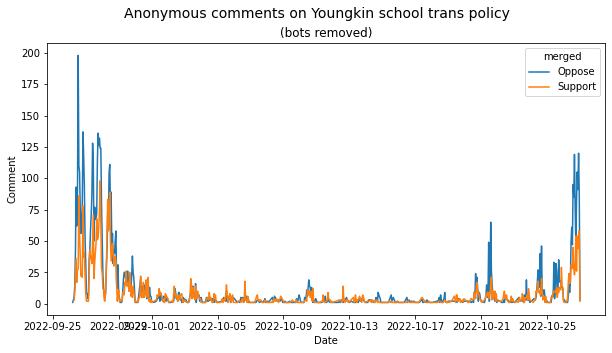

In [32]:
anon_ts = anon.set_index('Date').groupby([pd.Grouper(freq='1h'), 'merged']).count().loc[:,['Comment']].reset_index()

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = 'Date', y = 'Comment', data = anon_ts, hue = 'merged', ax=ax)
fig.suptitle('Anonymous comments on Youngkin school trans policy', fontsize=14)
ax.set_title('(bots removed)')
plt.savefig("images/anon_ts_nobots.png", facecolor='white')
plt.show()

In [38]:
anon.loc[(anon['merged']=='Support') & (anon['Date'] > datetime(2022, 10, 26, 20, 0)) ].head(20)

,Comment Title,Comment,CommentID,Commenter,Date,label,pred,merged
7233,Support Trans and Non-Binary Kids,Life is difficult enough to navigate. Imagine...,201595.0,Anonymous,2022-10-26 20:02:00,Support,,Support
7235,Support!,The new policies honor the sacred role of pare...,201607.0,Anonymous,2022-10-26 20:04:00,Support,,Support
7236,Support trans kids,Support policies like these and suicide/self-h...,201609.0,Anonymous,2022-10-26 20:05:00,Support,,Support
7237,I support new pro-parent policies proposed by ...,The new policies honor the sacred role of pare...,201614.0,Anonymous,2022-10-26 20:05:00,Support,,Support
7242,Strongly support Gov. Younkins policy,Students are minors and parents have rights. S...,201645.0,Anonymous,2022-10-26 20:12:00,Support,,Support
7244,Support The model Policies 2022,Support The model Policies 2022,201649.0,Anonymous,2022-10-26 20:13:00,Support,,Support
7245,Strongly support,Thank you for standing for the constitution an...,201653.0,Anonymous,2022-10-26 20:14:00,Support,,Support
7246,Strongly support,The new policies honor the sacred role of pare...,201656.0,Anonymous,2022-10-26 20:14:00,Support,,Support
7249,Support,I support parent’s rights until the child turn...,201675.0,Anonymous,2022-10-26 20:18:00,Support,,Support
7251,SUPPORT 2022 Trans Gender Policy,I believe the parents have the right to be inf...,201682.0,Anonymous,2022-10-26 20:19:00,Support,,Support


In [74]:
anon

,Comment Title,Comment,CommentID,Commenter,Date,label,pred,merged
0,Support!,"As a public school teacher, THANK YOU! I don't...",128971.0,Anonymous,2022-09-26 07:31:00,Support,,Support
1,Strongly support all people being who they are,Everyone is different. Everyone deserves to be...,128976.0,Anonymous,2022-09-26 07:38:00,Support,,Support
2,This is about saving student lives - oppose th...,I strongly oppose these changes. Having worked...,128984.0,Anonymous,2022-09-26 07:54:00,Oppose,,Oppose
3,Strongly Oppose The Changes,Correct pronoun and name use is incredibly cri...,128992.0,Anonymous,2022-09-26 08:12:00,Oppose,,Oppose
4,Strongly Oppose,Leave the evangelists to do their Work outside...,128998.0,Anonymous,2022-09-26 08:18:00,Oppose,,Oppose
...,...,...,...,...,...,...,...,...
7112,Trans people,I feel that trans people should be able to dec...,181340.0,Anonymous,2022-09-29 19:49:00,Unknown,Oppose,Oppose
7113,Best practice,"As a professional educator, this is a very sim...",181348.0,Anonymous,2022-09-29 19:52:00,Unknown,Support,Support
7114,100% agree with Governor Youngkin‘s policies o...,Honest doctors know that gender dysphoria is s...,181382.0,Anonymous,2022-09-29 20:13:00,Unknown,Support,Support
7115,"Duh, repeat post much?",Free for all,181396.0,Anonymous,2022-09-29 20:20:00,Unknown,Oppose,Oppose


In [35]:
# drop duplicates from Output set
dups = output_df.groupby(['Comment Title','Comment']).count().loc[:,['CommentID']]
dups = dups.loc[dups['CommentID']>5] # 396 comments
output_df.set_index(['Comment Title','Comment'], inplace=True)
print(f"Duplicates removed: {output_df.loc[output_df.index.isin(dups.index)].shape[0]}") 
output_df = output_df.loc[~output_df.index.isin(dups.index)]
output_df.reset_index(inplace=True)
print(f"Remaining records: {output_df.shape[0]}")

Duplicates removed: 33304
Remaining records: 37994


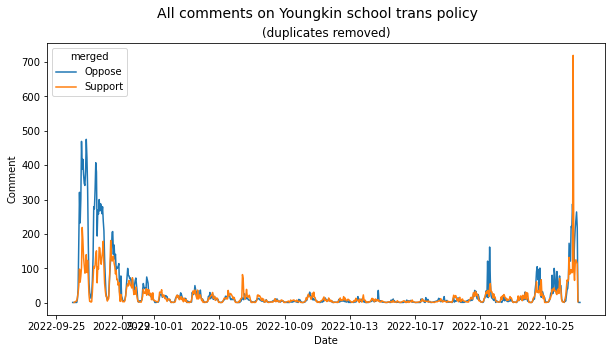

In [36]:
output_df['merged'] = output_df['pred'].replace('',np.NaN).fillna(output_df['label'])
out_ts = output_df.set_index('Date').groupby([pd.Grouper(freq='1h'), 'merged']).count().loc[:,['Comment']].reset_index()

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = 'Date', y = 'Comment', data = out_ts, hue = 'merged', ax=ax)
fig.suptitle('All comments on Youngkin school trans policy', fontsize=14)
ax.set_title('(duplicates removed)')
plt.savefig("images/all_ts.png", facecolor='white')
plt.show()

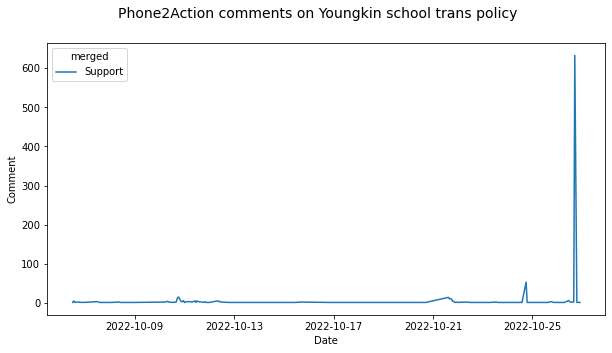

In [51]:
# peak at 2022-10-26 17:00
#output_df.loc[output_df['Date'].between(datetime(2022, 10, 26, 17, 0), datetime(2022, 10, 26, 18, 0)) & (output_df['merged']=='Support')]
p2a = output_df.loc[output_df['Comment Title']=='Protect Emotionally Vulnerable Children and Parental Rights!']
p2s_ts = p2a.set_index('Date').groupby([pd.Grouper(freq='1h'), 'merged']).count().loc[:,['Comment']].reset_index()


fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = 'Date', y = 'Comment', data = p2s_ts, hue = 'merged', ax=ax)
fig.suptitle('Phone2Action comments on Youngkin school trans policy', fontsize=14)
#ax.set_title('(duplicates removed)')
plt.show()

In [50]:
output_df.iloc[37166]['Comment']

'Dear Virginia Dept of Education,<br /><br />Schools should never secretly socially transition students and keep the child\'s new name, pronouns and gender identities from parents. I am pleased and relieved that the Virginia Department of Education\'s revised model policies support parental rights and ensure that school employees don\'t cut parents out of critical decisions for their children.<br /><br />The Virginia Department of Education (VDOE) issued "model policies" in 2021 that encouraged every school district in Virginia to hide a child\'s new gender identity from parents who choose to affirm the child\'s biological sex. Under Governor Youngkin\'s leadership, the VDOE\'s revised policies make it clear that all children should be valued and parents\' rights and beliefs should be respected. The 2022 Model Policies on the Privacy, Dignity, and Respect for all Students and Parents in Virginia\'s Public Schools keep parents involved in major decisions in their children\'s lives.<br /

In [53]:
counts = output_df.groupby('merged')['CommentID'].count()
data = counts.values
labels = list(counts.index)


output_orig = train.loc[:,['CommentID','Commenter','Comment Title','Comment','Date','label','pred']]
output_orig = output_orig.append(unk.loc[:,['CommentID','Commenter','Comment Title','Comment','Date','label','pred']])
output_orig['merged'] = output_orig['pred'].replace('',np.NaN).fillna(output_orig['label'])
counts2 = output_orig.groupby('merged')['CommentID'].count()
data2 = counts2.values
labels2 = list(counts2.index)

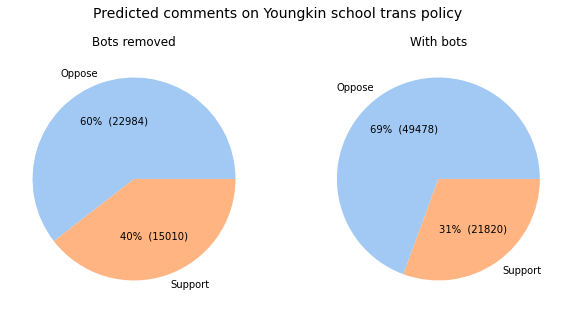

In [54]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.0f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct


#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Predicted comments on Youngkin school trans policy', fontsize=14)

ax1.pie(data, labels = labels, colors = colors, autopct=make_autopct(data))
ax1.set_title('Bots removed')

ax2.pie(data2, labels = labels2, colors = colors, autopct=make_autopct(data2))
ax2.set_title('With bots')

plt.savefig("images/outcome_pie.png", facecolor='white')
plt.show()

In [55]:
output_orig.shape

(71298, 8)

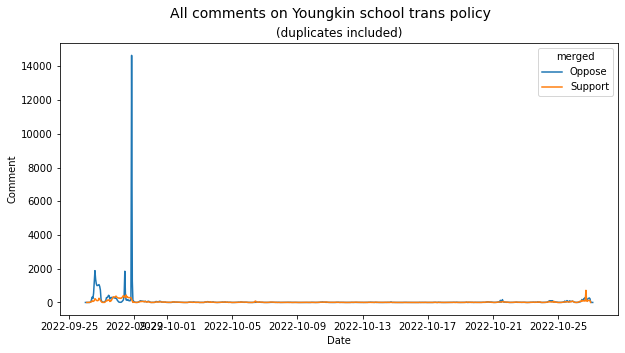

In [56]:
outbots_ts = output_orig.set_index('Date').groupby([pd.Grouper(freq='1h'), 'merged']).count().loc[:,['Comment']].reset_index()

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = 'Date', y = 'Comment', data = outbots_ts, hue = 'merged', ax=ax)
fig.suptitle('All comments on Youngkin school trans policy', fontsize=14)
ax.set_title('(duplicates included)')
plt.savefig("images/all_ts_withbots.png", facecolor='white')
plt.show()

In [102]:
32629 / (32629+19600)

0.6247295563767256